In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
%matplotlib inline

In [25]:
#  Implementing linear regression with one variable to predict profits for a food truck.

In [47]:
## Helper Functions:

def ymod(x,m,b,mu=0,sigma=1): 
    # Generating data for a linear model with gaussian noise
    # (mx + b + gaussian noise)
    return m*x + b + np.random.normal(mu,sigma,1)[0]

def ymodNL(x,a,b,c,mu=0,sigma=1): 
    # Generating data for a NON-linear model with gaussian noise
    # (b + m2sinx + m1cosx + gaussian noise)
    return a + b*math.sin(x) + c*math.cos(x) + np.random.normal(mu,sigma,1)[0]

def normalizeData(x,y,m=1,tratio=0.8):
    train_idx = int(len(x)*tratio)
    rawdata   = np.vstack((x,y))
    np.random.shuffle(rawdata.T)
    # split data into train/test
    X_Traindata = rawdata[0:m,:train_idx]
    Y_Traindata = rawdata[-1,:train_idx]
    X_Testdata  = rawdata[0:m,(train_idx+1):]
    Y_Testdata  = rawdata[-1,(train_idx+1):]
    # Normalize data along min
    absXmin = [np.min(X_Traindata,axis=1),np.min(X_Testdata,axis=1)]
    absXmax = [np.max(X_Traindata,axis=1),np.max(X_Testdata,axis=1)]
    for ind in range(m):
        X_Traindata[ind,:] = (X_Traindata[ind,:] - absXmin[0][ind]) / (absXmax[0][ind] - absXmin[0][ind])
        X_Testdata[ind,:]  = (X_Testdata[ind,:] - absXmin[1][ind]) / (absXmax[1][ind] - absXmin[1][ind])
    if m == 1:
        return (X_Traindata[0,:],X_Testdata[0,:]),(Y_Traindata,Y_Testdata)
    return (X_Traindata,X_Testdata),(Y_Traindata,Y_Testdata)
# Closed form Solution: 1
def MLEregression(phi,labels,lam=0.1):
    # w1 = np.dot(np.dot(np.linalg.inv(np.dot(phi.T,phi)),phi),x)
    # design matrix, phi, N X M
    # Solution 1:          
    M = phi.shape[1]#    [regularizer turm]
    temp1 = np.linalg.inv(lam*np.eye(M)+np.dot(phi.T,phi)) 
    temp2 = np.dot(temp1, phi.T)  
    w1 = np.dot(temp2,labels) #solution 
    return w1
# Stochastic Gradient Descent Method
def stochasticGradientDescent(X, y, theta, alpha = 0.01, iters=100):
    temp = np.matrix(np.zeros(theta.shape))
    parameters = int(theta.ravel().shape[1])
    
    cost = np.zeros(iters)
    
    for i in range(iters):
        # record error to compute gradient =>  dL/dw = (yhat - y) * x
        error = (X * theta.T) - y 
        # shuffle order of weights
        porder = np.arange(parameters)
        np.random.shuffle(porder)
        for j in porder:
            term = np.multiply(error, X[:,j])
            temp[0,j] = theta[0,j] - ((alpha / len(X)) * np.sum(term))
            
        theta = temp
        cost[i] = computeCost(X, y, theta)    
    return theta, cost

def computeCost(X, y, theta):
    inner = np.power(((X * theta.T) - y), 2)
    return np.sum(inner) / (2 * len(X))

In [27]:
## Look at data
path = os.getcwd() + '/data/ex1data1.txt'
data = pd.read_csv(path, header=None, names=['Population', 'Profit'])
data.head()

,Population,Profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


In [28]:
# Stats of data
data.describe()

,Population,Profit
count,97.000000,97.000000
mean,8.159800,5.839135
std,3.869884,5.510262
min,5.026900,-2.680700
25%,5.707700,1.986900
50%,6.589400,4.562300
75%,8.578100,7.046700
max,22.203000,24.147000


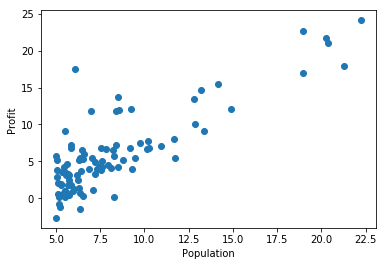

In [29]:
# Visualizing data
plt.plot(data['Population'],data['Profit'],'o')
plt.xlabel('Population')
plt.ylabel('Profit')
plt.show()

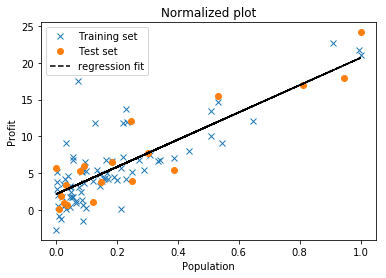

Objective loss  9.55475943232
Validation Error  6.62448128293


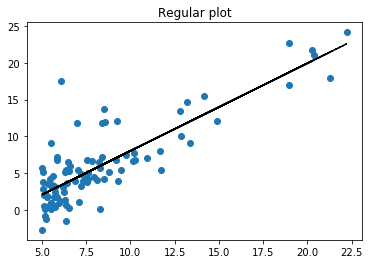

In [30]:
# Maximum Likelihood approach (Closed Solution)             
#                                  [Kernel] <- phi [N (# data points) x M (# free parameters)]
# p(x|ND(u,sig)) => ∏p(x|ND(np.dot(w,phi.T(x)),sig))
#   Maximumum likelihood Approach STEPS 
# .... 1. find J = ln[p(x|ND(u,sig))] 
# .... 2. set derivative of d(J)/d(w) = 0
# ....    - w = np.dot(phi.T,x)/(np.dot(phi,phi.T))  


# split data into train/test
x = data['Population'] # independent var
y = data['Profit'] 
# Normalize data
(nXtrain,nXtest),(Ytrain,Ytest) = normalizeData(x,y,m=1,tratio=0.8)
# Solve for MLE model
# Model 1:
N   = len(nXtrain)
phi = np.array([np.ones(N),nXtrain]).T # add biases 
model1 = MLEregression(phi,Ytrain)
# Model 2: 
N = len(x)
phi = np.array([np.ones(N),x]).T #add biases 
model2 = MLEregression(phi,y)
# Use model to predict output from train/test sets
predicted_train = [model1[0]+model1[1]*xi for xi in nXtrain]
predicted_test  = [model1[0]+model1[1]*xi for xi in nXtest]
# Visualize
plt.title("Normalized plot")
plt.plot(nXtrain,Ytrain,'x')
plt.plot(nXtest,Ytest,'o')
plt.plot(nXtrain,predicted_train,'k--')
plt.legend(['Training set','Test set','regression fit'])
plt.xlabel('Population')
plt.ylabel('Profit')
plt.show()
# Compare model error train/test sets
obj_train = np.sum(np.power(predicted_train - Ytrain,2))/len(predicted_train)
obj_test  = np.sum(np.power(predicted_test - Ytest,2))/len(predicted_test)
print("Objective loss ",obj_train)
print("Validation Error ", obj_test)
# Show how MLE model works on raw data
predicted_vals  = [model2[0]+model2[1]*xi for xi in x]
plt.title("Regular plot")
plt.plot(x,y,'o')
plt.plot(x,predicted_vals,'k--')
plt.show()

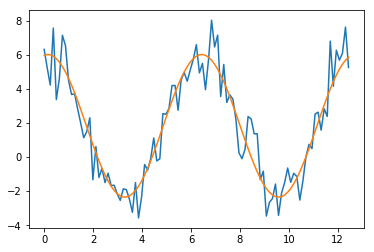

In [31]:
# closed form MLE for non-linear functions [kernels]
N = 101
M = 3
t = np.empty(N)
domain = np.empty(N)
domain_bound = 4.0*math.pi/N
for i in range(N): domain[i] = i * domain_bound
for i in range (N): t[i] = ymodNL(x=domain[i],a=1.85,b=0.57,c=4.37)
#design matrix, phi, N X M
c1 = [math.sin(x) for x in domain]
c2 = [math.cos(x) for x in domain]
# b + asinx + csinx
phi = np.array([np.ones(N),c1,c2]).T
#find the solution
model3 = MLEregression(phi,t)
#Solution 2: if phi is not invertible we could find the pseudo inverse using the pinv function
phi_pi = np.linalg.pinv(phi)
w3 = np.dot(phi_pi,t)
# Use model to predict outcome
predicted_t = [model3[0]+model3[1]*math.sin(x)+model3[2]*math.cos(x) for x in domain]
plt.plot(domain,t)
plt.plot(domain, predicted_t)
plt.show()

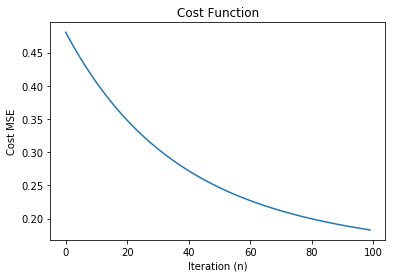

In [48]:
# Stochastic Gradient Descent Approach
path = os.getcwd() + '/data/ex1data2.txt'
data2 = pd.read_csv(path, header=None, names=['Size', 'Bedrooms', 'Price'])
# Normalize data
data2 = (data2 - data2.mean()) / data2.std()
# add bias column
data2.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
cols = data2.shape[1]
X2 = data2.iloc[:,0:cols-1]
y2 = data2.iloc[:,cols-1:cols]

# convert to matrices and initialize theta
X2 = np.matrix(X2.values)
y2 = np.matrix(y2.values)
theta2 = np.matrix(np.array([0,0,0]))

# perform linear regression on the data set
alpha = 0.01 # learning rate
iters = 100  # number of iterations
g2, cost2 = stochasticGradientDescent(X2, y2, theta2, alpha, iters)

# get the cost (error) of the model
computeCost(X2, y2, g2)
plt.plot(cost2)
plt.title('Cost Function')
plt.ylabel('Cost MSE')
plt.xlabel('Iteration (n)')
plt.show()